# Sample data reading test

In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

ModuleNotFoundError: No module named 'numpy'

In [2]:
class IAMLinesDataset:
    def __init__(self, data_path, xml_path=None, transform=None):
        """
        Initialize the IAM Lines dataset processor.
        
        Args:
            data_path (str): Path to the lines.tgz file or extracted directory
            xml_path (str, optional): Path to the xml.tgz file or extracted directory
            transform (callable, optional): Optional transform to be applied on images
        """
        self.data_path = data_path
        self.xml_path = xml_path
        self.transform = transform
        self.lines_path = None
        self.xml_parsed = None
        self.lines_df = None
        
        self._extract_data()
        
        if self.xml_path:
            self._parse_xml()
            
        self._build_lines_df()
        
    def _extract_data(self):
        """Extract the lines.tgz file if it's not already extracted"""
        if os.path.isfile(self.data_path) and self.data_path.endswith('.tgz'):
            # Create directory for extraction
            extract_dir = os.path.join(os.path.dirname(self.data_path), 'lines')
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            # Extract the tarfile
            with tarfile.open(self.data_path, 'r:gz') as tar:
                tar.extractall(path=extract_dir)
            
            self.lines_path = extract_dir
        else:
            # Assume data_path is already the directory with extracted lines
            self.lines_path = self.data_path
            
        # Extract XML if provided
        if self.xml_path and os.path.isfile(self.xml_path) and self.xml_path.endswith('.tgz'):
            extract_dir = os.path.join(os.path.dirname(self.xml_path), 'xml')
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
                
            with tarfile.open(self.xml_path, 'r:gz') as tar:
                tar.extractall(path=extract_dir)
                
            self.xml_path = extract_dir
    
    def _parse_xml(self):
        """Parse the XML files to get transcription and metadata"""
        xml_files = []
        
        for root, _, files in os.walk(self.xml_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_files.append(os.path.join(root, file))
        
        parsed_data = {}
        
        for xml_file in xml_files:
            try:
                tree = ET.parse(xml_file)
                root = tree.getroot()
                
                # Get document name
                doc_name = os.path.splitext(os.path.basename(xml_file))[0]
                
                # Process each line
                for line in root.findall('.//line'):
                    line_id = line.get('id')
                    if line_id:
                        transcription = line.get('text', '')
                        parsed_data[line_id] = {
                            'transcription': transcription,
                            'doc_name': doc_name
                        }
            except Exception as e:
                print(f"Error parsing {xml_file}: {e}")
        
        self.xml_parsed = parsed_data
    
    def _build_lines_df(self):
        """Build a DataFrame containing information about all line images"""
        image_files = []
        
        # Find all line images
        for root, _, files in os.walk(self.lines_path):
            for file in files:
                if file.endswith('.png'):
                    full_path = os.path.join(root, file)
                    # The file structure is like: lines/[writer]/[writer]-[doc]/[writer]-[doc]-[line].png
                    # Extract line ID from filename
                    line_id = os.path.splitext(file)[0]
                    
                    # Get path components
                    components = full_path.split(os.sep)
                    writer_id = components[-3] if len(components) >= 3 else None
                    doc_id = components[-2] if len(components) >= 2 else None
                    
                    item = {
                        'line_id': line_id,
                        'image_path': full_path,
                        'writer_id': writer_id,
                        'doc_id': doc_id
                    }
                    
                    # Add transcription if available
                    if self.xml_parsed and line_id in self.xml_parsed:
                        item['transcription'] = self.xml_parsed[line_id]['transcription']
                    
                    image_files.append(item)
        
        # Create DataFrame
        self.lines_df = pd.DataFrame(image_files)
        
    def get_dataframe(self):
        """Return the DataFrame containing line information"""
        return self.lines_df
    
    def get_image(self, idx):
        """Load an image by its index in the DataFrame"""
        if self.lines_df is None:
            raise ValueError("DataFrame not built yet")
        
        row = self.lines_df.iloc[idx]
        image_path = row['image_path']
        
        # Open image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            
        return image, row
    
    def __len__(self):
        """Return the number of line images"""
        if self.lines_df is None:
            return 0
        return len(self.lines_df)
    
    def __getitem__(self, idx):
        """Get an item by index (compatible with PyTorch Dataset)"""
        return self.get_image(idx)

In [3]:
class IAMLinesDatasetPyTorch(Dataset):
    def __init__(self, iam_dataset, indices=None, transform=None):
        """
        PyTorch Dataset wrapper for IAMLinesDataset
        
        Args:
            iam_dataset (IAMLinesDataset): The IAM dataset instance
            indices (list, optional): Specific indices to use
            transform (callable, optional): Additional transforms
        """
        self.iam_dataset = iam_dataset
        self.transform = transform
        self.indices = indices if indices is not None else list(range(len(iam_dataset)))
        
    def __len__(self):
        """Return the number of samples"""
        return len(self.indices)
    
    def __getitem__(self, idx):
        """Get a sample"""
        image, metadata = self.iam_dataset.get_image(self.indices[idx])
        
        if self.transform:
            image = self.transform(image)
            
        transcription = metadata.get('transcription', '')
            
        return {
            'image': image,
            'transcription': transcription,
            'line_id': metadata['line_id'],
            'writer_id': metadata['writer_id'],
            'doc_id': metadata['doc_id']
        }


def visualize_samples(dataset, num_samples=5, figsize=(15, 10)):
    """Visualize random samples from the dataset"""
    fig, axes = plt.subplots(num_samples, 1, figsize=figsize)
    
    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample['image']
        
        if image.dim() == 3 and image.shape[0] == 1: 
            image = image.squeeze(0).numpy()
        else:
            image = image.numpy()
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Line ID: {sample['line_id']}\nTranscription: {sample['transcription']}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
data_path = 'data/lines.tgz'  # Path to lines.tgz
xml_path = 'data/xml.tgz'     # Path to xml.tgz

In [5]:
iam_dataset = IAMLinesDataset(data_path, xml_path)

/var/folders/0s/yrh812y14q74q3467kyc44080000gn/T/ipykernel_56790/312353225.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)
/var/folders/0s/yrh812y14q74q3467kyc44080000gn/T/ipykernel_56790/312353225.py:49: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


In [6]:
df = iam_dataset.get_dataframe()

In [7]:
len(df)

13353

In [8]:
iam_dataset.get_image(1)

(<PIL.Image.Image image mode=L size=1770x146>,
 line_id                                                 e04-127-05
 image_path                   data/lines/e04/e04-127/e04-127-05.png
 writer_id                                                      e04
 doc_id                                                     e04-127
 transcription    into a variety of shapes they can be combined ...
 Name: 1, dtype: object)

In [9]:
transform = transforms.Compose([
    # Resize to a fixed height while maintaining aspect ratio
    transforms.Lambda(lambda img: transforms.functional.resize(
        img, (64, int(img.width * 64 / img.height)))),
    # Additional transforms can be added as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
pytorch_dataset = IAMLinesDatasetPyTorch(iam_dataset, transform=transform)

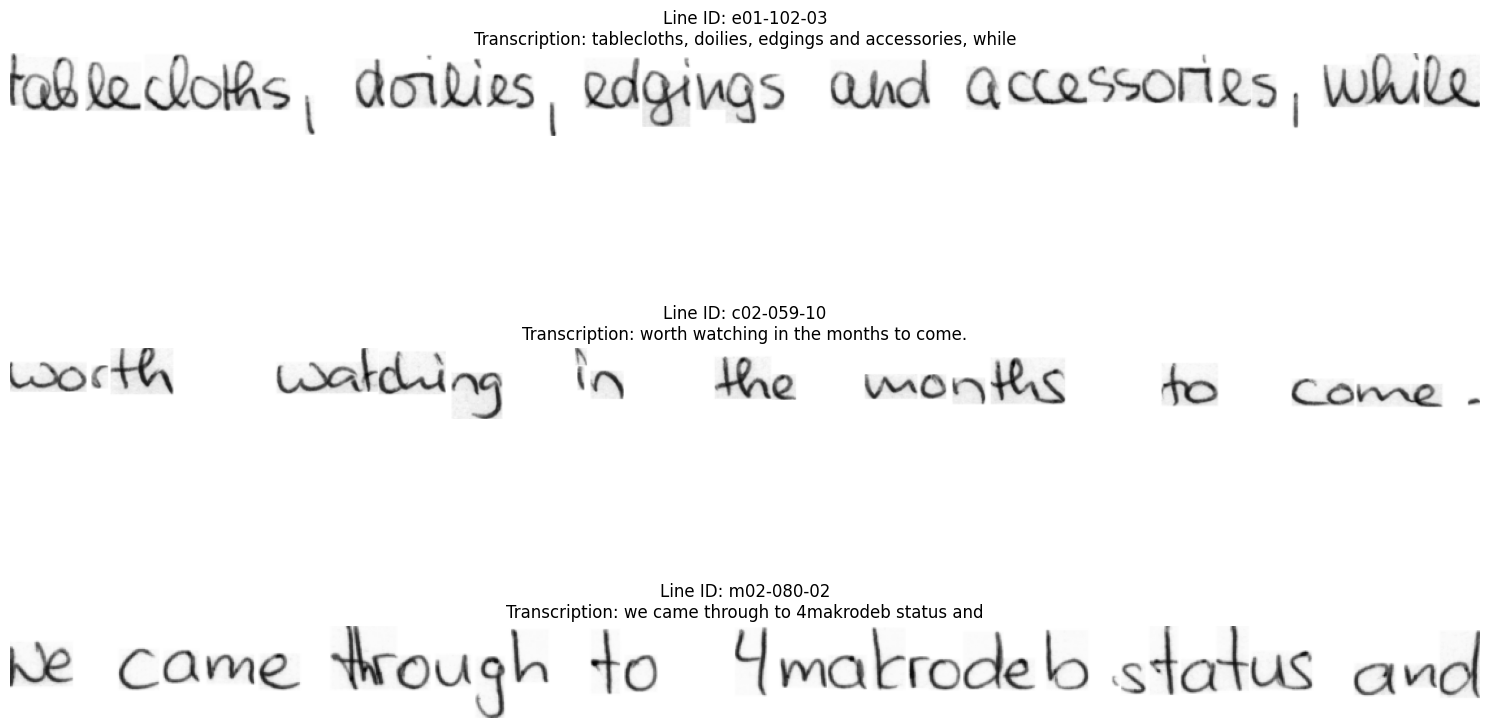

In [10]:
visualize_samples(pytorch_dataset, num_samples=3)